In [113]:
import os

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import time
from copy import deepcopy

import matplotlib.pyplot as plt
from IPython import display

### Loading data (MNIST)

In [ ]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


In [4]:
def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x


def plot_sample_img(img, name):
    img = img.view(1, 28, 28)
    save_image(img, './sample_{}.png'.format(name))


def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)

In [5]:
batch_size = 128
learning_rate = 1e-3

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1))
])


In [7]:
train_data = MNIST(root='./data', train=True,
                                   download=True, transform=img_transform)
test_data = MNIST(root='./data', train=False,
                                  download=True, transform=img_transform)

In [8]:
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

__Building autoencoder__

* We will test several encoders with different latent space size

In [9]:
class autoencoder(nn.Module):
    def __init__(self, hidden_size=64):
        super(autoencoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, self.hidden_size),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(self.hidden_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
def train_model(model, criterion, optimizer, train_loder, test_loader, num_epochs=100):
    train_loss = []
    test_loss = []
    
    best_test_loss = np.inf
    try:
        for epoch in range(num_epochs):
            train_loss_per_epoch = [] 
            train_mse_per_epoch = []
            test_loss_per_epoch = []
            
            for data in train_loder:
                img, _ = data
                img = img.view(img.size(0), -1)
                img = Variable(img) #.cuda()
                # ===================forward=====================
                output = model(img)
                loss = criterion(output, img)
                MSE_loss = nn.MSELoss()(output, img)
                train_mse_per_epoch.append(MSE_loss.item())
                train_loss_per_epoch.append(loss.item())
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_loss.append(np.mean(train_loss_per_epoch))
            
            with torch.no_grad():
                for data in test_loader:
                    img, _ = data
                    img = img.view(img.size(0), -1)
                    img = Variable(img) #.cuda()
                
                    output = model(img)
                    loss = criterion(output, img)
                    test_loss_per_epoch.append(loss.item())
                
                test_loss.append(np.mean(test_loss_per_epoch))
                    
            # ===================log========================
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("loss")
            plt.xlabel("number of epoch")
            plt.ylabel("loss")
            plt.plot(train_loss, 'b', label = "Train data")
            plt.plot(test_loss, 'r', label = "Test data")
            plt.legend()
            plt.show()


            print('epoch [{}/{}], train loss:{:.4f}, train MSE_loss:{:.4f}, test loss:{:.4f}, best test loss: {:.4f}'
                  .format(epoch + 1, num_epochs, train_loss[-1], np.mean(train_mse_per_epoch), test_loss[-1],
                         best_test_loss))
            if epoch % 10 == 0:
                x = to_img(img.data)
                x_hat = to_img(output.data)
                save_image(x, './mlp_img/x_{}.png'.format(epoch))
                save_image(x_hat, './mlp_img/x_hat_{}.png'.format(epoch))

            if test_loss[-1] < best_test_loss:
                best_test_loss = test_loss[-1]
                torch.save(model.state_dict(), f"./linear_autoencoder_{model.hidden_size}.pth")
            
    except KeyboardInterrupt:
        pass

In [11]:
model = autoencoder(64) #.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 80

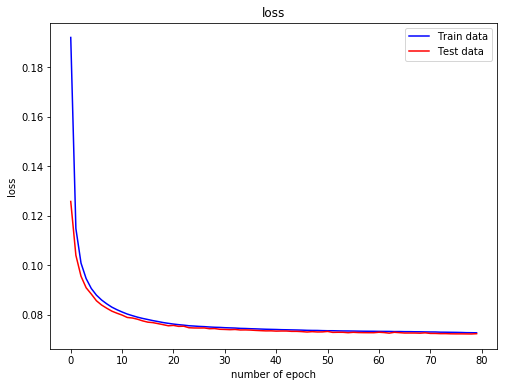

epoch [80/80], train loss:0.0726, train MSE_loss:0.0038, test loss:0.0722, best test loss: 0.0721


In [12]:
train_model(model, criterion, optimizer, dataloader, test_loader, num_epochs)

In [13]:
model2 = autoencoder(32) #.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model2.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 80

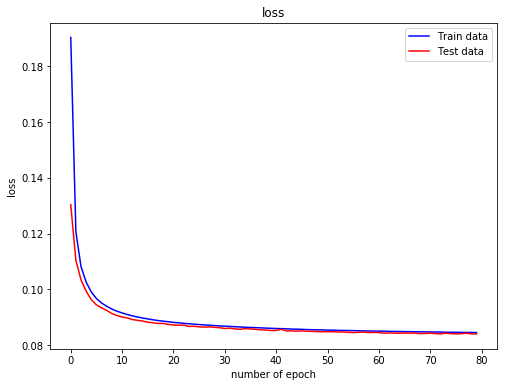

epoch [80/80], train loss:0.0846, train MSE_loss:0.0075, test loss:0.0841, best test loss: 0.0841


In [14]:
train_model(model2, criterion, optimizer, dataloader, test_loader, num_epochs)

In [15]:
model3 = autoencoder(128) #.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model3.parameters(), lr=learning_rate, weight_decay=1e-5)
num_epochs = 80

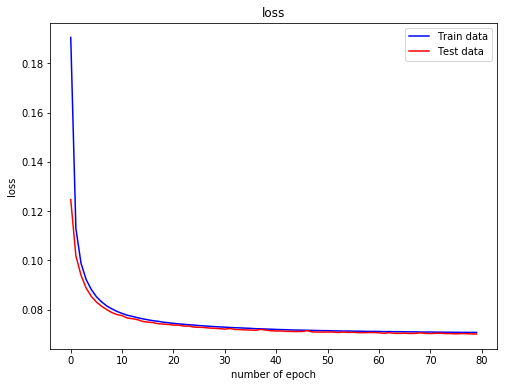

epoch [80/80], train loss:0.0708, train MSE_loss:0.0032, test loss:0.0702, best test loss: 0.0702


In [16]:
train_model(model3, criterion, optimizer, dataloader, test_loader, num_epochs)

__Examples of encoding__

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

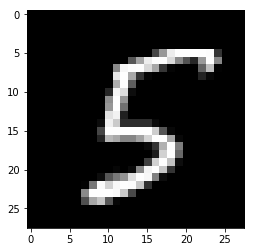

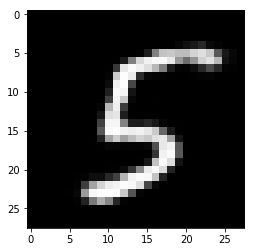

In [20]:
for data in test_loader:
    idx = 23
    img, _ = data
    plt.imshow(img[idx][0], cmap='gray')
    plt.show()
    plt.imshow(model(img.view(img.size(0), -1)[idx]).data.view(28, 28), cmap='gray')
    break

We trained simple linear autoencoder with the hidden sizes 32, 64 and 128. All of them have similar MSE and loss scores.

Now we explore wether it's possible to calculate functions on latent space. 

__1. Bollean function:__

F(X) = I(X - even number), X -> x, g(x) = I(X - even number)

In [88]:
class binary_func(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 2))

    def forward(self, x):
        x = self.net(x)
        return x

__With latent space size = 64__

In [83]:
boolean_function = binary_func(64)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(boolean_function.parameters(), lr=learning_rate, weight_decay=1e-5)

In [84]:
def train_binary_model(boolean_function, criterion, optimizer, train_loder, test_loader, model, num_epochs=60):
    train_loss = []
    test_loss = []
    best_test_loss = np.inf
    try:
        for epoch in range(num_epochs):
            train_loss_per_epoch = [] 
            test_loss_per_epoch = []
            correct = 0
            total = 0
            for data in train_loder:
                img, label = data
                boolean_mask = label.numpy()%2==0
                boolean_mask = torch.Tensor(boolean_mask.astype(int)).long()

                img = img.view(img.size(0), -1)

                with torch.no_grad():
                    encodding = model.encoder(img)

                output = boolean_function(encodding)

                loss = criterion(output, boolean_mask)
                train_loss_per_epoch.append(loss.item())

                _, predicted = torch.max(output.data, 1)
                total += boolean_mask.size(0)
                correct += (predicted == boolean_mask).sum().item()

                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss.append(np.mean(train_loss_per_epoch))

            with torch.no_grad():
                test_correct = 0
                test_total = 0
                for data in test_loader:
                    img, label = data
                    boolean_mask = label.numpy()%2==0
                    boolean_mask = torch.Tensor(boolean_mask.astype(int)).long()

                    img = img.view(img.size(0), -1)

                    encodding = model.encoder(img)
                    output = boolean_function(encodding)

                    loss = criterion(output, boolean_mask)
                    test_loss_per_epoch.append(loss.item())

                    _, predicted = torch.max(output.data, 1)
                    test_total += boolean_mask.size(0)
                    test_correct += (predicted == boolean_mask).sum().item()

                test_loss.append(np.mean(test_loss_per_epoch))
            # ===================log========================
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("loss")
            plt.xlabel("number of epoch")
            plt.ylabel("loss")
            plt.plot(train_loss, 'b', label = "Train data")
            plt.plot(test_loss, 'r', label = "Test data")
            plt.legend()
            plt.show()

            print('epoch [{}/{}], train loss:{:.4f}, train acc:{:.4f}, test loss:{:.4f}, test acc:{:.4f}, best_test_loss :{:.4f}'
                  .format(epoch + 1, num_epochs, np.mean(train_loss_per_epoch), 100 * correct / total,
                          np.mean(test_loss_per_epoch), 100 * test_correct / test_total, best_test_loss))

            if test_loss[-1] < best_test_loss:
                best_test_loss = test_loss[-1]
                torch.save(model.state_dict(), f"./binary_function_model2.pth")

    except KeyboardInterrupt:
        pass

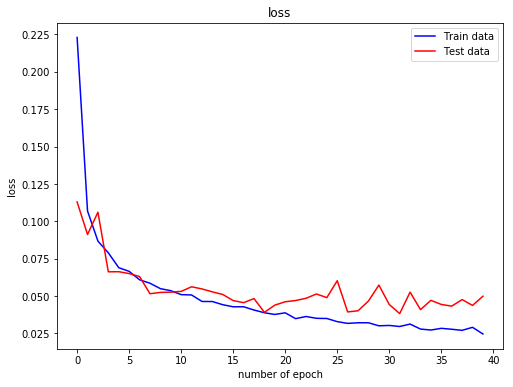

epoch [40/40], train loss:0.0246, train acc:99.1233, test loss:0.0499, test acc:98.4800, best_test_loss :0.0383


In [42]:
train_binary_model(boolean_function, criterion, optimizer, dataloader, test_loader, model, num_epochs=40)

__With latent space size = 32__

In [89]:
boolean_function2 = binary_func(32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(boolean_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

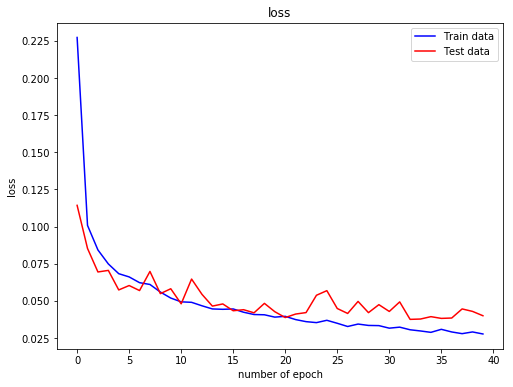

epoch [40/40], train loss:0.0277, train acc:99.0217, test loss:0.0400, test acc:98.6000, best_test_loss :0.0375


In [90]:
train_binary_model(boolean_function2, criterion, optimizer, dataloader, test_loader, model2, num_epochs=40)

__With latent space size = 128__

In [92]:
boolean_function3 = binary_func(128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(boolean_function3.parameters(), lr=learning_rate, weight_decay=1e-5)

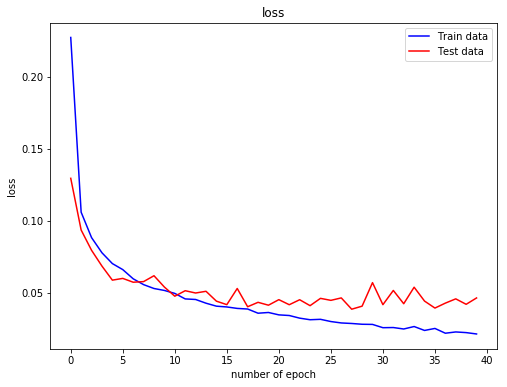

epoch [40/40], train loss:0.0214, train acc:99.2417, test loss:0.0464, test acc:98.4400, best_test_loss :0.0386


In [93]:
train_binary_model(boolean_function3, criterion, optimizer, dataloader, test_loader, model3, num_epochs=40)

In [116]:
pd.DataFrame({'test cross entropy': [0.0383, 0.0375, 0.0386], 
 'test accuracy': [98.4800, 98.60, 98.44], 'train accuracy': [99.1233, 99.0217, 99.2417]},
            index = ['size: 64', 'size: 32', 'size: 128'])

,test cross entropy,test accuracy,train accuracy
size: 64,0.0383,98.48,99.1233
size: 32,0.0375,98.60,99.0217
size: 128,0.0386,98.44,99.2417


Almost no change in scores, therefore, for MNIST and this boolean function we can take the smallest size of the latent space because it take less time. 

__2. Continuous function:__

F(X) = mean intensity of X, X -> x, g(x) = mean intensity of X

In [ ]:
for data in dataloader:
    img, label = data
    img = img.view(img.size(0), -1)
    print(torch.mean(img, dim=1))
    print(torch.mean(img, dim=1).shape)
    break

In [94]:
class cont_func(nn.Module):
    def __init__(self, hid_size=16):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(64, hid_size),
            nn.ReLU(True),
            nn.Linear(hid_size, 1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.net(x)
        return x

__Hidden size of the model is 16__

In [52]:
continuous_function = cont_func(16)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(continuous_function.parameters(), lr=learning_rate, weight_decay=1e-5)

In [53]:
def train_cont_model(continuous_function, criterion, optimizer, train_loder, test_loader, model, num_epochs=60):
    train_loss = []
    test_loss = []
    best_test_loss = np.inf
    try:
        for epoch in range(num_epochs):
            train_loss_per_epoch = [] 
            test_loss_per_epoch = []

            for data in train_loder:
                img, label = data
                img = img.view(img.size(0), -1)
                target = torch.mean(img, dim=1).unsqueeze(1)

                with torch.no_grad():
                    encodding = model.encoder(img)

                output = continuous_function(encodding)

                loss = criterion(output, target)
                train_loss_per_epoch.append(loss.item())

                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss.append(np.mean(train_loss_per_epoch))

            with torch.no_grad():
                for data in test_loader:
                    img, label = data
                    img = img.view(img.size(0), -1)
                    target = torch.mean(img, dim=1).unsqueeze(1)

                    encodding = model.encoder(img)
                    output = continuous_function(encodding)

                    loss = criterion(output, target)
                    test_loss_per_epoch.append(loss.item())

                test_loss.append(np.mean(test_loss_per_epoch))
            # ===================log========================
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("loss")
            plt.xlabel("number of epoch")
            plt.ylabel("loss")
            plt.plot(train_loss, 'b', label = "Train data")
            plt.plot(test_loss, 'r', label = "Test data")
            plt.legend()
            plt.show()

            print('epoch [{}/{}], train loss:{:.6f}, test loss:{:.6f}, best_test_loss:{:.6f}'
                  .format(epoch + 1, num_epochs, np.mean(train_loss_per_epoch), np.mean(test_loss_per_epoch),
                         best_test_loss))

            if test_loss[-1] < best_test_loss:
                best_test_loss = test_loss[-1]
                torch.save(model.state_dict(), f"./continuous_function.pth")

    except KeyboardInterrupt:
        pass

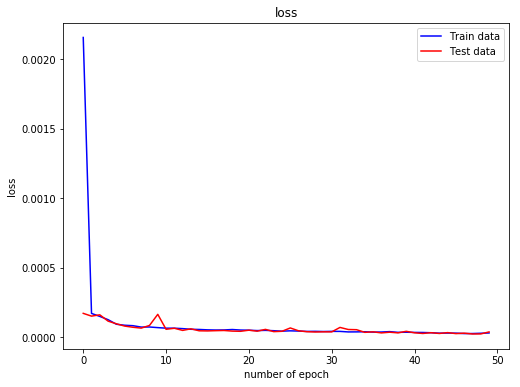

epoch [50/50], train loss:0.000029, test loss:0.000036, best_test_loss:0.000021


In [54]:
train_cont_model(continuous_function, criterion, optimizer, dataloader, test_loader, model, num_epochs=50)

__Hidden size of the model is 8__

In [95]:
continuous_function2 = cont_func(8)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(continuous_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

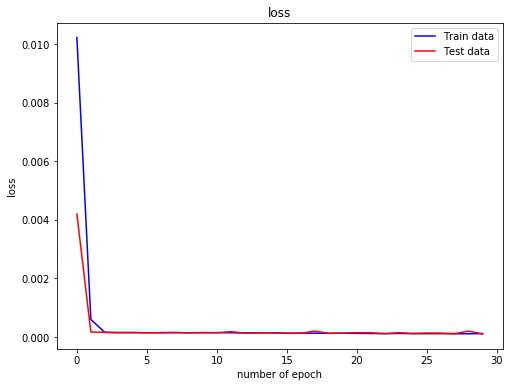

epoch [30/30], train loss:0.000118, test loss:0.000105, best_test_loss:0.000115


In [96]:
train_cont_model(continuous_function2, criterion, optimizer, dataloader, test_loader, model, num_epochs=30)

In [55]:
losses = []
for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    target = torch.mean(img, dim=1).unsqueeze(1)
#         img = Variable(img) #.cuda()
    # ===================forward=====================
    with torch.no_grad():
        encodding = model.encoder(img)

        output = continuous_function(encodding)
        
        loss = criterion(output, target)

        losses.append(loss.item())
print(np.mean(losses))

3.614521548011977e-05


In [118]:
pd.DataFrame({'best test mse': [0.000115, 0.000021], 
 'train mse': [0.000118, 0.000029]},
            index = ['hiden size: 8', 'hiden size: 16'])

,best test mse,train mse
hiden size: 8,0.000115,0.000118
hiden size: 16,0.000021,0.000029


Here the scores are better in case of larger hiden space, if we have resources, better to use larger neural network

### Parametric functions

Ф(Х) - функция, зависящая от набора параметров Ф(Х, P). Примеры: Ф(Х, Р) - значение пикселя с координатой Р,  Ф(Х, Р) - сумма по строке с номером Р, Ф(Х, Р) = corr(X, P)

__Ф(Х, Р) - сумма по строке с номером Р__

In [99]:
class params_func(nn.Module):
    def __init__(self, img_dim, latent_dim=64):
        super().__init__()
        self.img_dim = img_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim+self.img_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.ReLU(True))

    def forward(self, x, p):
        input_x = torch.cat([x, p], dim=1)
        output = self.net(input_x)
        return output

In [ ]:
for data in test_loader:
    img, label = data
    print(img.shape)
    print(torch.sum(img[:, 0, 20], dim=1).unsqueeze(1).shape)
    break
#     img = img.view(img.size(0), -1)

__With latent space size = 64__

In [77]:
parametric_function = params_func(28)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parametric_function.parameters(), lr=learning_rate, weight_decay=1e-5)

In [78]:
def train_param_model(parametric_function, criterion, optimizer, train_loder, test_loader, model, num_epochs=100):
    train_loss = []
    test_loss = []
    best_test_loss = np.inf
    try:
        for epoch in range(num_epochs):
            train_loss_per_epoch = [] 
            test_loss_per_epoch = []

            for data in train_loder:
                img, label = data
                ps = torch.zeros((img.shape[0], 28))
                target = []
                for i in range(img.shape[0]):
                    idx = np.random.randint(0, 28)
                    target.append(torch.sum(img[i, 0, idx]))
                    ps[i][idx] = 1.
                target = torch.stack(target).unsqueeze(1)

                img = img.view(img.size(0), -1)

                with torch.no_grad():
                    encodding = model.encoder(img)

                output = parametric_function(encodding, ps)

                loss = criterion(output, target)
                train_loss_per_epoch.append(loss.item())

                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss.append(np.mean(train_loss_per_epoch))

            with torch.no_grad():
                for data in test_loader:
                    img, label = data
                    ps = torch.zeros((img.shape[0], 28))
                    target = []
                    for i in range(img.shape[0]):
                        idx = np.random.randint(0, 28)
                        target.append(torch.sum(img[i, 0, idx]))
                        ps[i][idx] = 1.
                    target = torch.stack(target).unsqueeze(1)

                    img = img.view(img.size(0), -1)

                    encodding = model.encoder(img)
                    output = parametric_function(encodding, ps)

                    loss = criterion(output, target)
                    test_loss_per_epoch.append(loss.item())

                test_loss.append(np.mean(test_loss_per_epoch))
            # ===================log========================
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("loss")
            plt.xlabel("number of epoch")
            plt.ylabel("loss")
            plt.plot(train_loss, 'b', label = "Train data")
            plt.plot(test_loss, 'r', label = "Test data")
            plt.legend()
            plt.show()

            print('epoch [{}/{}], train loss:{:.4f}, test loss:{:.4f}, best test loss:{:.4f}'
                  .format(epoch + 1, num_epochs, np.mean(train_loss_per_epoch), np.mean(test_loss_per_epoch),
                         best_test_loss))

            if test_loss[-1] < best_test_loss:
                best_test_loss = test_loss[-1]
                torch.save(model.state_dict(), f"./parametric_function0.pth")

    except KeyboardInterrupt:
        pass

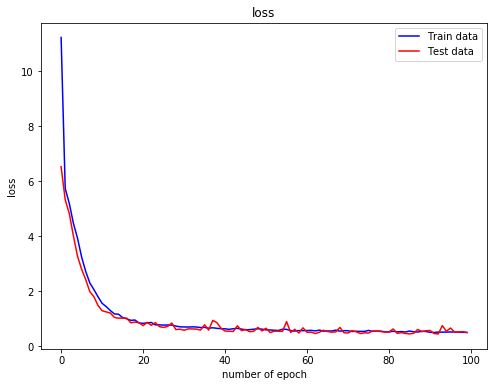

epoch [100/100], train loss:0.5030, test loss:0.4988, best test loss:0.4466


In [79]:
train_param_model(parametric_function, criterion, optimizer, dataloader, test_loader, model, num_epochs=100)

In [62]:
with torch.no_grad():
    for data in test_loader:
        img, label = data
        ps = torch.zeros((img.shape[0], 28))
        target = []
        for i in range(img.shape[0]):
            idx = np.random.randint(0, 28)
            target.append(torch.sum(img[i, 0, idx]))
            ps[i][idx] = 1.
        target = torch.stack(target).unsqueeze(1)
                
        img = img.view(img.size(0), -1)
            
        encodding = model.encoder(img)
        output = parametric_function(encodding, ps)
        print(np.concatenate([output.numpy(), target.numpy()], 1))

[[ 0.          2.3529413 ]
 [ 3.5966034   3.2509804 ]
 [ 1.4552176   1.5725491 ]
 [ 9.758614   11.258824  ]
 [ 0.31694221  0.        ]
 [ 2.6629798   3.2362204 ]
 [ 7.2033205   7.164706  ]
 [ 0.          0.        ]
 [ 2.9245868   1.0352942 ]
 [ 2.195272    3.3490195 ]
 [ 6.6242943   5.5607843 ]
 [ 6.343602    6.3686275 ]
 [ 2.756712    2.6156864 ]
 [ 5.4799266   4.9529414 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 1.9373946   2.301961  ]
 [ 7.3439083   5.854902  ]
 [ 9.266495    8.200001  ]
 [ 9.663956   10.266666  ]
 [ 2.6098614   1.9607843 ]
 [ 1.559917    2.4941177 ]
 [ 1.740969    1.5607843 ]
 [ 8.393886    7.905882  ]
 [ 0.9561517   1.4094489 ]
 [ 9.138125    8.631373  ]
 [ 1.4318485   1.7450981 ]
 [ 0.          0.        ]
 [ 5.1564875   5.196079  ]
 [ 0.          0.        ]
 [ 9.045785    8.917646  ]
 [ 0.          0.        ]
 [ 3.4905457   3.511811  ]
 [ 4.169443    4.6509805 ]
 [ 5.268138    4.4313726 ]
 [ 0.          0.        ]
 [ 2.6315513   2.5803921 ]
 

[[ 1.667691    2.7401574 ]
 [ 3.7992187   2.7882352 ]
 [ 0.45255852  0.        ]
 [ 1.5563152   1.5921569 ]
 [ 1.8398056   2.0078433 ]
 [ 3.5607955   4.301961  ]
 [ 6.3670015   6.184314  ]
 [ 0.          0.        ]
 [ 5.344243    4.337255  ]
 [ 3.8400924   4.0039215 ]
 [ 0.98114717  1.1764708 ]
 [ 2.6557305   2.4039216 ]
 [ 5.868778    6.443137  ]
 [ 5.3405704   5.6980395 ]
 [ 2.177434    2.439216  ]
 [ 0.9218863   1.3764706 ]
 [ 2.2279382   2.8078432 ]
 [ 3.1902313   3.1529412 ]
 [ 5.5743837   5.745098  ]
 [ 2.0351238   2.0392158 ]
 [ 1.3836782   2.0392158 ]
 [ 3.478191    3.3058825 ]
 [ 6.949933    9.050981  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 3.0842469   3.0901961 ]
 [ 0.71677566  1.6377953 ]
 [ 0.          0.        ]
 [ 2.991272    3.0666666 ]
 [ 0.          0.        ]
 [ 2.6766086   3.67451   ]
 [ 4.066045    3.2431374 ]
 [ 8.936876    9.882354  ]
 [ 7.006859    7.121569  ]
 [ 0.          1.1181103 ]
 [ 2.9568028   2.517647  ]
 [ 4.8760843   5.098039  ]
 

[[ 2.5898376   4.090196  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 1.983121    2.0627453 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.8989909   3.2784314 ]
 [ 6.8197927   4.9254904 ]
 [ 0.          0.        ]
 [ 7.226116    8.490196  ]
 [ 9.275686    9.4       ]
 [ 0.          0.        ]
 [11.8447895  11.413386  ]
 [ 8.3263235   7.8000007 ]
 [ 4.7319293   5.9647055 ]
 [ 1.022184    0.99215686]
 [ 1.9471498   2.1803923 ]
 [ 5.644222    5.3960786 ]
 [ 1.7598612   2.0509803 ]
 [ 4.15212     4.1803923 ]
 [ 5.676254    5.337255  ]
 [ 0.          0.        ]
 [ 1.2257371   1.9882352 ]
 [ 0.          0.        ]
 [ 5.653404    5.1490197 ]
 [ 3.0582411   4.0862746 ]
 [ 0.686998    0.        ]
 [ 4.064027    4.258824  ]
 [ 2.8143868   3.3019607 ]
 [ 5.5381656   6.670588  ]
 [ 0.          0.        ]
 [ 3.6740985   3.3098037 ]
 [ 3.788718    3.5882354 ]
 [ 4.8903246   5.1968503 ]
 [ 1.0140196   1.3607843 ]
 [ 0.95495284  2.2941177 ]
 [ 2.518141    2.6039217 ]
 

[[ 6.15554     5.8392158 ]
 [ 0.          0.        ]
 [ 3.7598302   3.9058821 ]
 [12.361832   13.411764  ]
 [ 0.          0.        ]
 [ 3.41951     3.0823529 ]
 [ 3.0534348   4.7058825 ]
 [ 3.5542898   3.407843  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 3.0609894   3.070588  ]
 [ 0.          0.        ]
 [ 2.0531402   2.0745099 ]
 [ 7.131785    7.152941  ]
 [ 0.          0.        ]
 [ 8.656131    9.227451  ]
 [ 1.1288217   1.968504  ]
 [ 0.          0.        ]
 [ 5.224764    6.0156865 ]
 [ 8.10377     8.22353   ]
 [ 3.4212909   3.7686276 ]
 [ 0.9523194   1.9764706 ]
 [ 0.          0.        ]
 [ 6.811756    6.521569  ]
 [ 5.639457    5.8588233 ]
 [ 2.654759    2.662745  ]
 [ 7.433711    7.250981  ]
 [ 2.768033    2.929412  ]
 [ 7.9479628   8.023529  ]
 [ 0.          0.        ]
 [ 1.9981866   2.1843138 ]
 [ 1.4981253   1.5607843 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.3132493   3.3019607 ]
 [ 3.7646978   3.2549021 ]
 [ 3.0629454   2.6117644 ]
 

[[ 5.173422    4.7843137 ]
 [ 9.635833   10.203921  ]
 [ 6.6461563   8.580392  ]
 [ 6.7499356   6.3622046 ]
 [ 5.9075866   6.03937   ]
 [10.463591    9.905882  ]
 [ 2.2375531   2.3411765 ]
 [ 5.762504    5.992157  ]
 [ 2.6060567   2.9764707 ]
 [ 2.8857057   2.9803922 ]
 [ 0.          0.        ]
 [ 1.0078092   2.035294  ]
 [ 0.          0.        ]
 [ 2.9752479   2.3686275 ]
 [ 0.          0.        ]
 [ 3.6938665   4.0470586 ]
 [ 0.          0.        ]
 [ 4.991881    6.333334  ]
 [ 1.8750901   2.2322834 ]
 [ 7.5295286   7.094118  ]
 [ 0.          0.        ]
 [ 9.287998    7.882353  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 1.4862103   1.4941176 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 3.3443646   4.058823  ]
 [ 8.692149    9.552942  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 4.5119324   4.46063   ]
 [ 9.154533    8.866667  ]
 [ 6.103117    5.5590553 ]
 [ 0.          0.        ]
 

[[ 5.8058205  6.1732287]
 [ 0.         0.9137255]
 [ 0.         0.       ]
 [ 7.1491337  8.286274 ]
 [ 5.6754856  5.321569 ]
 [10.293654   8.27451  ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 5.6152706  4.8980393]
 [ 4.778326   5.0235295]
 [ 3.4351144  3.8862743]
 [ 0.         0.       ]
 [ 5.3932476  5.645669 ]
 [ 3.446029   3.3921568]
 [ 4.940084   5.576471 ]
 [11.689856  12.078741 ]
 [ 5.013605   4.9098043]
 [ 7.0792074  6.929412 ]
 [ 0.         0.       ]
 [ 5.5625134  4.594488 ]
 [ 2.315489   2.827451 ]
 [ 0.         0.       ]
 [ 2.619275   3.3921568]
 [ 4.7637043  5.219608 ]
 [ 0.         0.       ]
 [ 1.5017102  1.8980392]
 [ 0.         0.       ]
 [ 8.600406   9.349021 ]
 [ 5.2001915  5.9725494]
 [ 9.484282   9.278432 ]
 [ 2.666364   2.537255 ]
 [ 2.4739804  3.6784315]
 [12.686729  14.141177 ]
 [ 3.486811   3.3921568]
 [ 6.33669    6.4588237]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [12.231758  11.964706 ]


[[ 6.1750298   6.9490204 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 3.5875165   5.054902  ]
 [ 2.463189    1.972441  ]
 [ 2.3163147   2.180392  ]
 [ 0.          0.        ]
 [ 1.8237166   2.7725492 ]
 [ 2.0943494   2.3019607 ]
 [ 4.816794    4.686275  ]
 [ 0.          0.        ]
 [ 5.8019886   5.909449  ]
 [ 5.9366384   5.1568627 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 6.2065      5.629922  ]
 [ 7.003751    6.6431375 ]
 [ 4.1852045   4.6509805 ]
 [ 3.4523687   2.8117647 ]
 [ 1.4260406   1.8862746 ]
 [ 0.          0.        ]
 [ 4.15961     3.3490198 ]
 [ 4.576623    4.5019608 ]
 [ 0.          0.        ]
 [ 3.0111294   3.4470592 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 1.4869136   1.8862746 ]
 [ 2.1783824   2.5019608 ]
 [ 9.114265   10.894118  ]
 [ 6.5880647   5.7843137 ]
 [ 2.01816     2.1929133 ]
 [ 0.          0.        ]
 [ 2.746314    2.7843137 ]
 [ 0.          0.        ]
 [ 6.0734406   6.1725492 ]
 

[[ 6.977014    6.6941175 ]
 [ 0.          0.        ]
 [ 2.840066    2.7764707 ]
 [ 0.          0.        ]
 [ 5.9910707   5.627451  ]
 [ 2.7967188   2.5843136 ]
 [ 1.9390408   1.7176472 ]
 [ 3.3058853   2.345098  ]
 [ 0.          0.        ]
 [ 6.647067    6.741177  ]
 [ 4.5476604   5.564706  ]
 [ 6.5524282   6.153543  ]
 [ 0.78435653  1.3411765 ]
 [ 0.          0.        ]
 [ 0.73441553  1.3490196 ]
 [ 6.043499    6.7725496 ]
 [ 3.564172    3.7529411 ]
 [ 4.249497    3.7333333 ]
 [ 0.          0.        ]
 [ 5.8188467   5.333334  ]
 [ 9.48966     9.0039215 ]
 [ 2.1826844   2.945098  ]
 [ 3.286183    3.2313726 ]
 [ 5.0357847   5.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 3.1870434   3.4117646 ]
 [ 8.550175    8.262746  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.1024678   0.32283464]
 [ 3.2372372   2.5490196 ]
 [ 8.032265    8.917647  ]
 [ 4.398614    5.6705885 ]
 [ 0.          0.        ]
 [ 8.163691    8.17255   ]
 [ 2.9777455   3.027451  ]
 

[[ 0.          0.        ]
 [ 2.1080437   2.3882353 ]
 [ 0.          0.        ]
 [ 5.7826967   6.0275593 ]
 [ 2.0135574   2.1764705 ]
 [ 2.4071555   2.854902  ]
 [ 3.1032853   3.0669293 ]
 [ 2.2578516   2.5882354 ]
 [ 5.459997    5.5686274 ]
 [ 0.          0.        ]
 [ 2.5630372   2.7764707 ]
 [ 3.5353076   4.0156865 ]
 [ 5.8169003   5.933334  ]
 [ 4.6864557   4.694118  ]
 [ 4.485143    4.250981  ]
 [12.029623   12.54902   ]
 [ 3.6190712   3.8       ]
 [ 4.869275    4.5019608 ]
 [ 3.8373873   3.647059  ]
 [ 5.8564005   6.447059  ]
 [ 4.2588096   4.54902   ]
 [ 8.888822    8.682354  ]
 [ 3.8587055   2.9411764 ]
 [ 5.4686236   5.0039215 ]
 [ 2.3208802   1.9803922 ]
 [ 1.977828    3.0313725 ]
 [ 4.9041314   5.2509804 ]
 [ 1.8103709   2.2941177 ]
 [ 2.867874    3.1529412 ]
 [ 6.0771756   7.3607845 ]
 [ 7.6600733   7.4980392 ]
 [ 0.44817913  0.20392159]
 [ 6.1123705   8.713726  ]
 [ 9.061442    8.705882  ]
 [ 5.612471    6.27451   ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 

[[ 5.876084    6.2549024 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 6.296343    7.121569  ]
 [ 5.5291767   5.6784315 ]
 [ 8.956427    8.894118  ]
 [11.6535635  10.200001  ]
 [ 0.          0.        ]
 [ 8.311169    9.819608  ]
 [ 4.524225    5.1647058 ]
 [ 0.          0.        ]
 [ 5.5289106   4.4235296 ]
 [ 3.7280743   3.2627454 ]
 [ 2.6149614   2.745098  ]
 [ 2.5286155   2.9176471 ]
 [ 2.692285    3.1960783 ]
 [ 6.269265    5.7686276 ]
 [ 2.5243654   2.337255  ]
 [ 2.9008055   2.8705883 ]
 [ 7.2532415   7.2784314 ]
 [ 0.          0.        ]
 [ 5.751546    5.470588  ]
 [ 5.327921    5.2470584 ]
 [ 0.          0.        ]
 [11.25888    12.482353  ]
 [ 0.          0.        ]
 [ 9.895155   10.258823  ]
 [ 6.738297    7.52756   ]
 [ 4.5203114   4.258824  ]
 [11.860277   10.87008   ]
 [ 2.9357884   2.952941  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [10.099652   10.12549   ]
 [ 3.0530872   3.3137257 ]
 

[[ 0.          0.        ]
 [ 8.31582     7.9058824 ]
 [ 2.0901346   2.0705884 ]
 [ 6.901329    7.9411774 ]
 [ 2.9801555   2.6901963 ]
 [ 0.          0.20784315]
 [ 3.874309    3.109804  ]
 [ 0.          0.        ]
 [ 4.864062    4.3725495 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 9.408024    9.560784  ]
 [ 0.          0.        ]
 [ 8.295736    9.25098   ]
 [ 7.349736    6.7716537 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 4.4601383   4.235294  ]
 [ 7.528463    7.498039  ]
 [ 0.          0.        ]
 [10.991478   10.662746  ]
 [ 3.221584    3.9568627 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 2.2528968   3.2862747 ]
 [ 3.0615282   2.7686274 ]
 [ 3.2064614   3.5764706 ]
 [ 0.          0.        ]
 [ 1.4198092   2.0784316 ]
 [ 4.1750245   4.8117647 ]
 [ 0.          0.        ]
 [ 2.8825502   3.003937  ]
 [ 6.810384    7.6588235 ]
 [ 4.997946    5.235294  ]
 [12.131325   14.403922  ]
 [ 0.          0.        ]
 

__With latent space size = 32__

In [100]:
parametric_function2 = params_func(28, latent_dim=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parametric_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

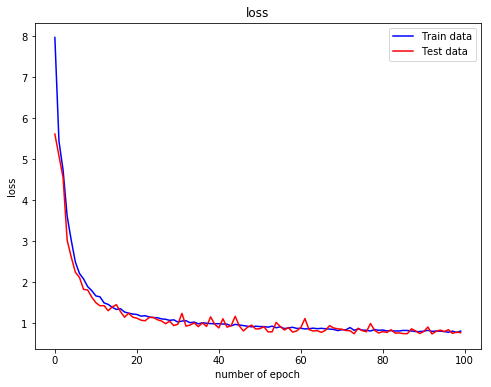

epoch [100/100], train loss:0.8103, test loss:0.7715, best test loss:0.7387


In [101]:
train_param_model(parametric_function2, criterion, optimizer, dataloader, test_loader, model2, num_epochs=100)

__With latent space size = 128__

In [102]:
parametric_function3 = params_func(28, latent_dim=128)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parametric_function3.parameters(), lr=learning_rate, weight_decay=1e-5)

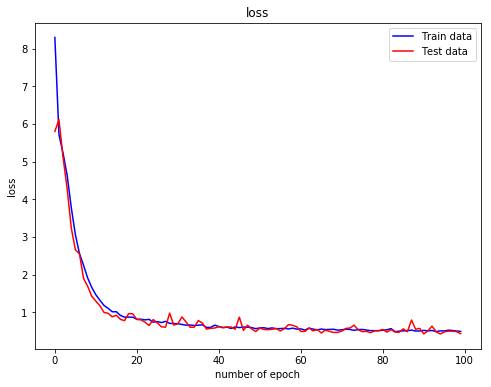

epoch [100/100], train loss:0.4923, test loss:0.4300, best test loss:0.4232


In [103]:
train_param_model(parametric_function3, criterion, optimizer, dataloader, test_loader, model3, num_epochs=100)

In [119]:
pd.DataFrame({'best test mse': [0.7387, 0.4466, 0.4232], 
 'train mse': [0.8103, 0.5030, 0.4923]},
            index = ['size: 32', 'size: 64', 'size: 128'])

,best test mse,train mse
size: 32,0.7387,0.8103
size: 64,0.4466,0.5030
size: 128,0.4232,0.4923


Here we see clear trend when larger network has better quality, depending on our resourced and needed quality we can decide on the architecture.

## P - coordinate

In [104]:
class params_func2(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.img_dim = img_dim
        self.net = nn.Sequential(
            nn.Linear(128+2*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 1),
            nn.Sigmoid())

    def forward(self, x, p):
        input_x = torch.cat([x, p], dim=1)
        output = self.net(input_x)
        return output

In [105]:
parametric_function2 = params_func2(28)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parametric_function2.parameters(), lr=learning_rate, weight_decay=1e-5)

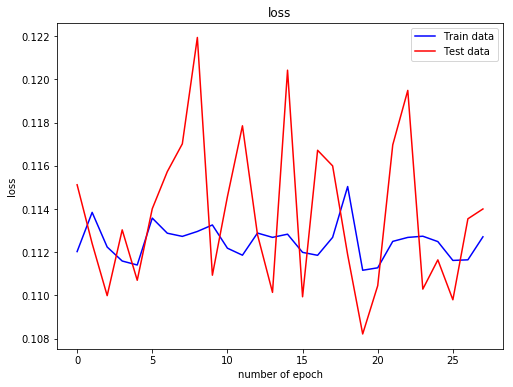

epoch [28/100], train loss:0.1127, test loss:0.1140, best test loss:0.1082


In [106]:
num_epochs = 100
train_loss = []
test_loss = []
best_test_loss = np.inf
try:
    for epoch in range(num_epochs):
        train_loss_per_epoch = [] 
        test_loss_per_epoch = []
        
        for data in dataloader:
            img, label = data
            p_x = torch.zeros((img.shape[0], 28))
            p_y = torch.zeros((img.shape[0], 28))
            target = []
            for i in range(img.shape[0]):
                id_x = np.random.randint(0, 28)
                id_y = np.random.randint(0, 28)
                target.append(img[i, 0, id_x, id_y])
                p_x[i][id_x] = 1.
                p_y[i][id_y] = 1.
                
            ps = torch.cat([p_x, p_y], dim=1)
            target = torch.stack(target).unsqueeze(1)

            img = img.view(img.size(0), -1)
            
            with torch.no_grad():
                encodding = model3.encoder(img)

            output = parametric_function2(encodding, ps)

            loss = criterion(output, target)
            train_loss_per_epoch.append(loss.item())

            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss.append(np.mean(train_loss_per_epoch))
            
        with torch.no_grad():
            for data in test_loader:
                img, label = data
                p_x = torch.zeros((img.shape[0], 28))
                p_y = torch.zeros((img.shape[0], 28))
                target = []
                for i in range(img.shape[0]):
                    id_x = np.random.randint(0, 28)
                    id_y = np.random.randint(0, 28)
                    target.append(img[i, 0, id_x, id_y])
                    p_x[i][id_x] = 1.
                    p_y[i][id_y] = 1.
                
                ps = torch.cat([p_x, p_y], dim=1)
                target = torch.stack(target).unsqueeze(1)
                
                img = img.view(img.size(0), -1)
            
                encodding = model3.encoder(img)
                output = parametric_function2(encodding, ps)
                
                loss = criterion(output, target)
                test_loss_per_epoch.append(loss.item())
                
            test_loss.append(np.mean(test_loss_per_epoch))
        # ===================log========================
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("loss")
        plt.xlabel("number of epoch")
        plt.ylabel("loss")
        plt.plot(train_loss, 'b', label = "Train data")
        plt.plot(test_loss, 'r', label = "Test data")
        plt.legend()
        plt.show()
            
        print('epoch [{}/{}], train loss:{:.4f}, test loss:{:.4f}, best test loss:{:.4f}'
              .format(epoch + 1, num_epochs, np.mean(train_loss_per_epoch), np.mean(test_loss_per_epoch),
                     best_test_loss))
        
        if test_loss[-1] < best_test_loss:
            best_test_loss = test_loss[-1]
            torch.save(model.state_dict(), f"./parametric_function2.pth")

except KeyboardInterrupt:
    pass

Trying different architectures and types of encodding the coordinate, it was not possible to train the network. 
One of the probable solutions is to shrink the parameters' space to a smaller one.

## P - arbitrary number image

In [63]:
from scipy.stats.stats import pearsonr   

In [107]:
class params_func3(nn.Module):
    def __init__(self, img_dim, lat_size=64):
        super().__init__()
        self.img_dim = img_dim
        self.net = nn.Sequential(
            nn.Linear(lat_size+self.img_dim*self.img_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 1))

    def forward(self, x, p):
        p = p[:x.size(0)]
        input_x = torch.cat([x, p], dim=1)
        output = self.net(input_x)
        return output

__With latent space size = 64__

In [65]:
parametric_function3 = params_func3(28)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parametric_function3.parameters(), lr=learning_rate, weight_decay=1e-5)

In [66]:
other_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
other_test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

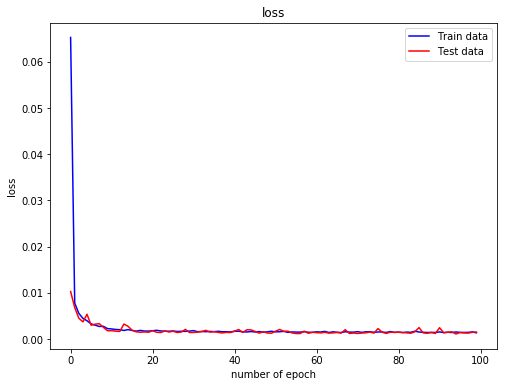

epoch [100/100], train loss:0.0014, test loss:0.0015, best test loss:0.0011


In [67]:
num_epochs = 100
train_loss = []
test_loss = []
best_test_loss = np.inf
try:
    for epoch in range(num_epochs):
        train_loss_per_epoch = [] 
        test_loss_per_epoch = []
        
        for data in dataloader:
            img, label = data
            img = img.view(img.size(0), -1)
            
            for other_data in other_dataloader:
                other_img, _ = other_data
                other_img = other_img[:img.size(0)]
                other_img = other_img.view(other_img.size(0), -1)
                break
            
            target = []
            for i in range(img.shape[0]):
                target.append(torch.tensor(pearsonr(img[i].numpy(), other_img[i].numpy())[0]))
            target = torch.stack(target).unsqueeze(1)

            with torch.no_grad():
                encodding = model.encoder(img)

            output = parametric_function3(encodding, other_img)

            loss = criterion(output, target)
            train_loss_per_epoch.append(loss.item())

            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss.append(np.mean(train_loss_per_epoch))
            
        with torch.no_grad():
            for data in test_loader:
                img, label = data
                img = img.view(img.size(0), -1)
                
                for other_data in other_test_loader:
                    other_img, _ = other_data
                    other_img = other_img.view(other_img.size(0), -1)
                    break
                
                target = []
                for i in range(img.shape[0]):
                    target.append(torch.tensor(pearsonr(img[i].numpy(), other_img[i].numpy())[0]))
                target = torch.stack(target).unsqueeze(1)
            
                encodding = model.encoder(img)
                output = parametric_function3(encodding, other_img)
                
                loss = criterion(output, target)
                test_loss_per_epoch.append(loss.item())
                
            test_loss.append(np.mean(test_loss_per_epoch))
        # ===================log========================
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("loss")
        plt.xlabel("number of epoch")
        plt.ylabel("loss")
        plt.plot(train_loss, 'b', label = "Train data")
        plt.plot(test_loss, 'r', label = "Test data")
        plt.legend()
        plt.show()
            
        print('epoch [{}/{}], train loss:{:.4f}, test loss:{:.4f}, best test loss:{:.4f}'
              .format(epoch + 1, num_epochs, np.mean(train_loss_per_epoch), np.mean(test_loss_per_epoch),
                     best_test_loss))
        
        
        if test_loss[-1] < best_test_loss:
            best_test_loss = test_loss[-1]
            torch.save(model.state_dict(), f"./parametric_function.pth")
                
except KeyboardInterrupt:
    pass

In [68]:
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = img.view(img.size(0), -1)

        for other_data in other_test_loader:
            other_img, _ = other_data
            other_img = other_img.view(other_img.size(0), -1)
            break

        target = []
        for i in range(img.shape[0]):
            target.append(torch.tensor(pearsonr(img[i].numpy(), other_img[i].numpy())[0]))
        target = torch.stack(target).unsqueeze(1)

        encodding = model.encoder(img)
        output = parametric_function3(encodding, other_img)
        print(np.concatenate([output.numpy(), target.numpy()], 1))

[[ 0.29302427  0.26511684]
 [ 0.08972526  0.1105414 ]
 [ 0.05334932  0.00510479]
 [ 0.29945254  0.26163942]
 [ 0.26069146  0.18288894]
 [ 0.47772443  0.47787538]
 [ 0.16423148  0.17186537]
 [ 0.37601742  0.35935238]
 [ 0.13670109  0.04316084]
 [ 0.14649493  0.14691864]
 [ 0.21434408  0.22478786]
 [ 0.32217675  0.28697652]
 [ 0.28029907  0.28656068]
 [ 0.42967832  0.44339597]
 [ 0.31097656  0.29244974]
 [ 0.30026352  0.24407294]
 [ 0.23970316  0.18792467]
 [ 0.24187732  0.22673438]
 [ 0.19135576  0.16654085]
 [ 0.14600088  0.11993813]
 [ 0.4807832   0.42625314]
 [ 0.14067617  0.09047894]
 [ 0.17997509  0.14664498]
 [ 0.63237613  0.59444565]
 [ 0.19022873  0.22807574]
 [ 0.31003124  0.30697036]
 [ 0.1333912   0.12441915]
 [ 0.51242614  0.5015212 ]
 [ 0.42515054  0.3961153 ]
 [ 0.05665123  0.06958953]
 [ 0.34335014  0.32032317]
 [ 0.07022566  0.04814892]
 [ 0.59559536  0.6066695 ]
 [-0.03548072 -0.0157474 ]
 [ 0.7373657   0.77393526]
 [ 0.17973846  0.17629509]
 [ 0.28677037  0.29563317]
 

[[ 2.0647201e-01  1.8541498e-01]
 [ 2.0008095e-01  1.8477379e-01]
 [ 3.2164603e-01  3.3533788e-01]
 [ 3.0597460e-01  2.7850744e-01]
 [ 1.4973626e-02  1.7713552e-02]
 [ 3.3003429e-01  2.6909834e-01]
 [ 1.6079819e-01  1.1693761e-01]
 [ 3.7424472e-01  3.6913195e-01]
 [ 1.5523171e-01  1.9086672e-01]
 [ 2.4210843e-01  2.2199795e-01]
 [ 5.1606327e-02  5.0968163e-02]
 [ 4.8758444e-01  4.5914108e-01]
 [-7.0001274e-02 -4.7206096e-02]
 [ 2.9827189e-01  2.2617692e-01]
 [ 3.8076445e-01  3.1949267e-01]
 [ 3.7447846e-01  4.0140876e-01]
 [ 2.9701146e-01  2.8506878e-01]
 [ 2.6560870e-01  2.9067421e-01]
 [ 1.6290711e-01  1.6968837e-01]
 [ 2.2996016e-01  2.0993222e-01]
 [ 1.8504962e-01  1.1845416e-01]
 [ 5.4903400e-01  4.9804008e-01]
 [ 5.6937230e-01  5.8282924e-01]
 [ 1.2853234e-01  1.3533860e-01]
 [ 2.9752022e-01  2.4934754e-01]
 [ 2.9588223e-01  2.7194253e-01]
 [ 1.6261369e-02  1.9307153e-02]
 [ 4.2541838e-01  4.0794167e-01]
 [ 5.8693957e-01  5.7389176e-01]
 [ 3.4354806e-01  3.4238043e-01]
 [ 2.49316

[[0.44426945 0.37450004]
 [0.23219581 0.18885717]
 [0.48686805 0.5002188 ]
 [0.4390418  0.43030432]
 [0.5986269  0.49385583]
 [0.24585253 0.23400791]
 [0.3915621  0.3842225 ]
 [0.43198362 0.4804146 ]
 [0.5479028  0.5126056 ]
 [0.5258212  0.51294833]
 [0.28791493 0.28708228]
 [0.27392548 0.1984121 ]
 [0.08779417 0.09155194]
 [0.15254803 0.1622123 ]
 [0.42859858 0.39456543]
 [0.12297767 0.11702918]
 [0.2420993  0.20680042]
 [0.29659718 0.25545666]
 [0.23326841 0.24462473]
 [0.4395596  0.43529797]
 [0.45983326 0.41887155]
 [0.42482913 0.35235056]
 [0.4107811  0.3960112 ]
 [0.21545002 0.20016587]
 [0.25535256 0.25806105]
 [0.4123563  0.45291466]
 [0.3836937  0.3317307 ]
 [0.44124827 0.41790497]
 [0.26276237 0.27177444]
 [0.19244021 0.15007584]
 [0.63899016 0.5679145 ]
 [0.4000157  0.33156103]
 [0.29399902 0.23816311]
 [0.4158556  0.37789434]
 [0.4010589  0.410709  ]
 [0.08989114 0.05667831]
 [0.18262075 0.14498687]
 [0.25905716 0.22841686]
 [0.21893935 0.21965455]
 [0.24237555 0.21938251]


[[ 0.19477248  0.14444453]
 [ 0.48405784  0.43350872]
 [ 0.14659445  0.18488061]
 [ 0.12378176  0.11249427]
 [ 0.5015478   0.458942  ]
 [ 0.4569167   0.4537361 ]
 [ 0.3557784   0.3039152 ]
 [ 0.496245    0.48845118]
 [ 0.0551018  -0.00745375]
 [ 0.1236975   0.11669702]
 [ 0.26357242  0.19690503]
 [ 0.31492215  0.25337422]
 [ 0.28892305  0.24592373]
 [ 0.19829957  0.14060107]
 [ 0.33166063  0.32729977]
 [ 0.3718953   0.30878595]
 [ 0.39672175  0.3962592 ]
 [ 0.17880341  0.12467867]
 [ 0.25560218  0.27859452]
 [ 0.34864706  0.31461322]
 [ 0.19131711  0.1832894 ]
 [ 0.30166918  0.28218734]
 [ 0.2445748   0.24516127]
 [ 0.46516514  0.4784506 ]
 [ 0.32545924  0.30145422]
 [ 0.09547234  0.09638137]
 [ 0.36137688  0.32182595]
 [ 0.2904569   0.3051526 ]
 [ 0.38444626  0.41802123]
 [ 0.4028145   0.3796149 ]
 [ 0.31320357  0.30315027]
 [ 0.35438213  0.3590303 ]
 [ 0.21073507  0.18854332]
 [ 0.35260475  0.32026926]
 [ 0.19367373  0.16496047]
 [ 0.21003309  0.255622  ]
 [ 0.6325305   0.6155156 ]
 

[[ 0.08992203  0.03855183]
 [ 0.22392437  0.181864  ]
 [ 0.23440218  0.21660297]
 [ 0.22268286  0.20439996]
 [ 0.18510923  0.16299821]
 [ 0.31075332  0.26898488]
 [ 0.5468043   0.5224399 ]
 [ 0.39716226  0.4375669 ]
 [ 0.2227842   0.18853347]
 [ 0.13900618  0.13171875]
 [ 0.37134576  0.32671028]
 [ 0.31983846  0.325359  ]
 [ 0.4267857   0.39259666]
 [ 0.28793383  0.30684546]
 [ 0.58362794  0.659487  ]
 [ 0.3252956   0.31249002]
 [ 0.5655991   0.56820184]
 [ 0.4713788   0.472084  ]
 [ 0.3060602   0.24659222]
 [ 0.48141614  0.39659348]
 [ 0.23827899  0.23345804]
 [ 0.36973298  0.32752252]
 [ 0.31730032  0.28503388]
 [ 0.3580553   0.29867765]
 [ 0.39636958  0.38459006]
 [ 0.26294345  0.28694913]
 [ 0.26880413  0.2667919 ]
 [ 0.3883832   0.44072828]
 [ 0.16443309  0.1776832 ]
 [ 0.36329752  0.36278358]
 [ 0.17729384  0.12666889]
 [ 0.5552274   0.59730613]
 [ 0.5120266   0.50744295]
 [ 0.18463376  0.09169921]
 [ 0.38858604  0.3141683 ]
 [ 0.37550265  0.3434476 ]
 [ 0.31940055  0.23118976]
 

[[0.16164878 0.11676232]
 [0.43005517 0.4293275 ]
 [0.34831423 0.3214132 ]
 [0.2774309  0.22458753]
 [0.11334649 0.03932801]
 [0.2626568  0.2215971 ]
 [0.26338398 0.24291977]
 [0.3539434  0.35279065]
 [0.3350805  0.32202074]
 [0.48824626 0.47856224]
 [0.1917797  0.16633248]
 [0.26535356 0.25842413]
 [0.22331125 0.2486715 ]
 [0.25643846 0.22878069]
 [0.24688616 0.20015223]
 [0.19599928 0.18734573]
 [0.66125005 0.5958094 ]
 [0.46566686 0.43704703]
 [0.27358696 0.26152194]
 [0.5403114  0.502335  ]
 [0.31921822 0.28120932]
 [0.21368158 0.19498768]
 [0.3270807  0.31366733]
 [0.49278376 0.46026358]
 [0.34861964 0.27135655]
 [0.43882006 0.4127475 ]
 [0.08029592 0.00587787]
 [0.17846161 0.12985323]
 [0.15169829 0.09450881]
 [0.39124918 0.40720746]
 [0.25933567 0.23985575]
 [0.39053798 0.41314623]
 [0.28284115 0.2605014 ]
 [0.27543312 0.19770649]
 [0.17334679 0.10103743]
 [0.4565155  0.43944535]
 [0.23984824 0.20349044]
 [0.33530858 0.3376432 ]
 [0.3226675  0.33447748]
 [0.33425906 0.31364948]


[[ 0.12772113  0.0493631 ]
 [ 0.39848506  0.32170224]
 [ 0.14004023  0.09787422]
 [ 0.26001912  0.25106463]
 [ 0.2940833   0.222714  ]
 [ 0.33686894  0.32893166]
 [ 0.44119355  0.40075073]
 [ 0.22012836  0.17692026]
 [ 0.21500722  0.2311072 ]
 [ 0.23984006  0.22991437]
 [ 0.3056351   0.32772377]
 [ 0.2883936   0.28130868]
 [ 0.6962722   0.6594283 ]
 [ 0.16226922  0.12285531]
 [ 0.60632265  0.60463905]
 [ 0.17449276  0.16755117]
 [ 0.34613708  0.27754402]
 [ 0.29494387  0.3208777 ]
 [ 0.2358702   0.19443086]
 [ 0.51424885  0.54648334]
 [ 0.34899518  0.32970482]
 [ 0.2359617   0.19143714]
 [ 0.25284684  0.19329186]
 [ 0.12465994  0.12647456]
 [ 0.10091625  0.0173645 ]
 [ 0.22309479  0.20761919]
 [ 0.46400163  0.42599759]
 [ 0.3868859   0.42197168]
 [ 0.19620714  0.18736893]
 [ 0.1190949   0.13042966]
 [ 0.5672717   0.5689147 ]
 [ 0.3015563   0.2662637 ]
 [ 0.26056057  0.27294478]
 [ 0.11140122  0.10422247]
 [ 0.2136448   0.1700667 ]
 [ 0.23882213  0.23094451]
 [ 0.38630658  0.40561002]
 

[[0.305786   0.30072656]
 [0.17299572 0.14952686]
 [0.3775838  0.3451963 ]
 [0.34122062 0.29013097]
 [0.21501718 0.19780381]
 [0.19680794 0.13655923]
 [0.2584967  0.27674204]
 [0.05231794 0.00810388]
 [0.30005246 0.2769629 ]
 [0.32955265 0.28605086]
 [0.31221133 0.29124635]
 [0.14631209 0.10060015]
 [0.08248463 0.07740645]
 [0.27495587 0.21709144]
 [0.2614849  0.28580633]
 [0.25148007 0.22042653]
 [0.31878382 0.2667318 ]
 [0.6060374  0.5061751 ]
 [0.45134008 0.41925192]
 [0.34277084 0.28771326]
 [0.20925654 0.2224186 ]
 [0.24454826 0.18823193]
 [0.22667292 0.18835406]
 [0.20107631 0.13796435]
 [0.3608474  0.31757373]
 [0.50264853 0.42592946]
 [0.34898895 0.21480401]
 [0.24159592 0.26278767]
 [0.2922357  0.24345215]
 [0.41438237 0.42494434]
 [0.5106623  0.53387016]
 [0.21753076 0.17833106]
 [0.46612263 0.40948102]
 [0.11398129 0.09962285]
 [0.20550068 0.17703047]
 [0.288697   0.25737914]
 [0.31919104 0.34418342]
 [0.43569037 0.3536889 ]
 [0.16121587 0.12914102]
 [0.4719027  0.42478365]


[[0.45982903 0.41840664]
 [0.41038364 0.40138316]
 [0.27195656 0.19504842]
 [0.25709057 0.27678972]
 [0.20399483 0.193891  ]
 [0.30247402 0.33655104]
 [0.14844517 0.14355029]
 [0.38028315 0.36565247]
 [0.42989928 0.3400984 ]
 [0.26143312 0.2374958 ]
 [0.21650799 0.19267255]
 [0.1473224  0.10250433]
 [0.34164697 0.4216615 ]
 [0.19093254 0.19093025]
 [0.49564597 0.4926273 ]
 [0.1623908  0.13968243]
 [0.37488174 0.34905335]
 [0.3844536  0.3098954 ]
 [0.3068239  0.27884236]
 [0.56289697 0.535476  ]
 [0.7001433  0.6189187 ]
 [0.15559907 0.1406496 ]
 [0.4373518  0.3851818 ]
 [0.3282253  0.37230146]
 [0.3407504  0.35396376]
 [0.74873513 0.9211078 ]
 [0.41755193 0.4107895 ]
 [0.15591304 0.12965776]
 [0.225703   0.19189301]
 [0.3482346  0.36385843]
 [0.3065315  0.32184124]
 [0.3002031  0.2923361 ]
 [0.06888174 0.05674618]
 [0.35842064 0.25684583]
 [0.19824298 0.16625193]
 [0.4032452  0.4058264 ]
 [0.49712062 0.51297635]
 [0.06658031 0.05885058]
 [0.29308617 0.2529189 ]
 [0.21377242 0.22833166]


[[0.29519308 0.27286908]
 [0.3869886  0.33047065]
 [0.03683193 0.03579519]
 [0.40513685 0.44998085]
 [0.12577292 0.13014577]
 [0.34384754 0.2874529 ]
 [0.29331928 0.2832962 ]
 [0.36395276 0.3654727 ]
 [0.38744658 0.34946105]
 [0.53407615 0.5119592 ]
 [0.3242903  0.35050657]
 [0.30791786 0.30557013]
 [0.1435826  0.12832183]
 [0.29181492 0.2875501 ]
 [0.26597494 0.2689697 ]
 [0.23367076 0.19780888]
 [0.45083532 0.44961917]
 [0.40092763 0.3251703 ]
 [0.32815993 0.43115675]
 [0.43878323 0.40255284]
 [0.54841685 0.5199533 ]
 [0.39917114 0.35539186]
 [0.60959536 0.6005839 ]
 [0.11635236 0.11666147]
 [0.5294514  0.4809455 ]
 [0.38957182 0.38937482]
 [0.29982454 0.32939166]
 [0.4594058  0.41507283]
 [0.18412285 0.156351  ]
 [0.44316655 0.39843902]
 [0.24163857 0.22433335]
 [0.14789665 0.1081538 ]
 [0.2885201  0.23859468]
 [0.34306556 0.2747097 ]
 [0.43437007 0.4221549 ]
 [0.20196052 0.19233464]
 [0.37282372 0.32718706]
 [0.13721839 0.09390967]
 [0.34830338 0.35657436]
 [0.48321688 0.47568837]


[[ 0.26864785  0.28857532]
 [ 0.10101881  0.13083586]
 [ 0.13812667  0.12119702]
 [ 0.36300343  0.33642608]
 [ 0.21050556  0.17529272]
 [ 0.35182205  0.30750272]
 [ 0.10663405  0.06758618]
 [ 0.19033872  0.20492125]
 [ 0.38481373  0.32199308]
 [ 0.1016722   0.11862497]
 [ 0.33929422  0.3858288 ]
 [ 0.13063788  0.12702642]
 [ 0.19657962  0.17061758]
 [ 0.4987469   0.46872127]
 [ 0.1269924   0.12302256]
 [ 0.23305207  0.20487392]
 [ 0.2838306   0.28127503]
 [ 0.29205135  0.29074627]
 [ 0.06360717  0.06162101]
 [ 0.11705428  0.14011785]
 [ 0.44721904  0.46081495]
 [ 0.34442857  0.30595767]
 [ 0.16334882  0.15095364]
 [ 0.5344231   0.48586687]
 [ 0.21279722  0.21341787]
 [ 0.5833882   0.6299857 ]
 [ 0.48151392  0.44352496]
 [ 0.40008152  0.37237108]
 [ 0.6033833   0.58231926]
 [ 0.44847703  0.4255674 ]
 [ 0.53026414  0.536231  ]
 [ 0.3789881   0.36162263]
 [ 0.40101737  0.3920968 ]
 [ 0.47043648  0.43517748]
 [ 0.10719529  0.1134363 ]
 [ 0.01526463 -0.01109131]
 [ 0.3401265   0.29202384]
 

[[ 0.15630233  0.15678181]
 [ 0.63023204  0.663679  ]
 [ 0.44697955  0.40036008]
 [ 0.32457462  0.3401508 ]
 [ 0.46011615  0.42823476]
 [ 0.15277839  0.09493655]
 [ 0.13232139  0.04466543]
 [ 0.26698634  0.26818433]
 [ 0.21703823  0.21042638]
 [ 0.15289003  0.170167  ]
 [ 0.17704132  0.18097219]
 [ 0.05700865  0.01296141]
 [ 0.11089002  0.06546892]
 [ 0.4725019   0.4140922 ]
 [ 0.51266485  0.55457443]
 [ 0.13852414  0.14963299]
 [ 0.44926643  0.3802175 ]
 [ 0.24310213  0.29375166]
 [ 0.30894485  0.3230952 ]
 [ 0.4307317   0.4230321 ]
 [ 0.5096619   0.5236825 ]
 [ 0.41069126  0.45288888]
 [ 0.44873822  0.5041694 ]
 [ 0.34244743  0.30762517]
 [ 0.23955864  0.24706444]
 [ 0.35273913  0.3625618 ]
 [ 0.15849929  0.13087744]
 [ 0.5579422   0.5005101 ]
 [ 0.50138813  0.55096567]
 [ 0.5084545   0.51651525]
 [ 0.11100273  0.05416761]
 [ 0.32897866  0.2947403 ]
 [ 0.30209348  0.23890337]
 [ 0.34234673  0.37899056]
 [ 0.37900132  0.38264018]
 [ 0.54793006  0.5740383 ]
 [ 0.19511223  0.2092857 ]
 

[[ 0.27941585  0.25477675]
 [ 0.4304585   0.35314777]
 [ 0.36303934  0.37815908]
 [ 0.21668419  0.21370177]
 [ 0.29850736  0.20200853]
 [ 0.6216546   0.5853242 ]
 [ 0.34715995  0.32073408]
 [ 0.35609528  0.35155085]
 [ 0.2080011   0.15952992]
 [ 0.3283338   0.33101818]
 [ 0.14090687  0.0958321 ]
 [ 0.4710206   0.44806564]
 [ 0.25142404  0.21725017]
 [ 0.30042648  0.24838686]
 [ 0.20299883  0.18422303]
 [ 0.17659384  0.10279563]
 [ 0.3698082   0.39496568]
 [ 0.15121591  0.14039336]
 [ 0.21771128  0.22077438]
 [ 0.13206446  0.06182652]
 [ 0.00428595 -0.00434497]
 [ 0.2998801   0.26854113]
 [ 0.3227098   0.30721432]
 [ 0.668354    0.74496907]
 [ 0.13708043 -0.01284711]
 [ 0.19766586  0.21382615]
 [ 0.29576182  0.2549438 ]
 [ 0.4881166   0.4818291 ]
 [ 0.2687996   0.25150168]
 [ 0.08355597  0.08369949]
 [ 0.5113555   0.5011639 ]
 [ 0.51543766  0.57808125]
 [ 0.46792182  0.33268833]
 [ 0.26311457  0.32710567]
 [ 0.3745768   0.46076712]
 [ 0.4377287   0.40377557]
 [ 0.57246     0.5605527 ]
 

[[ 0.34864938  0.31918818]
 [ 0.5899143   0.5962285 ]
 [ 0.29428267  0.3099067 ]
 [ 0.17947373  0.20108683]
 [ 0.34043786  0.24452253]
 [ 0.4701206   0.48028192]
 [ 0.33399802  0.27002376]
 [ 0.09084062  0.06493542]
 [ 0.30425858  0.32502586]
 [ 0.273303    0.24702905]
 [ 0.64920884  0.6353186 ]
 [ 0.37198463  0.33809197]
 [ 0.11339481  0.04259671]
 [ 0.0640254   0.05295809]
 [ 0.13620138  0.11300366]
 [ 0.24994597  0.21762393]
 [ 0.14139786  0.12093014]
 [ 0.47515327  0.43943295]
 [ 0.6300535   0.624897  ]
 [ 0.556647    0.5496267 ]
 [ 0.37339252  0.3462548 ]
 [ 0.37431437  0.30790478]
 [ 0.31306237  0.2742792 ]
 [ 0.18750827  0.19747958]
 [ 0.32741672  0.28015476]
 [ 0.36752325  0.39142805]
 [ 0.17189865  0.19106016]
 [ 0.3818521   0.37435216]
 [ 0.3516088   0.32238084]
 [ 0.26829466  0.2789506 ]
 [ 0.5232806   0.48121813]
 [ 0.23742194  0.19321842]
 [ 0.06521481 -0.00336594]
 [ 0.28900623  0.31664622]
 [ 0.2877183   0.19763975]
 [ 0.22345132  0.22441396]
 [ 0.62010604  0.5349426 ]
 

[[0.09453541 0.07735814]
 [0.20693833 0.21123198]
 [0.43542647 0.43141094]
 [0.47213647 0.49851233]
 [0.27397823 0.29868758]
 [0.14787525 0.18438324]
 [0.31582168 0.30119208]
 [0.3272698  0.3387001 ]
 [0.12484479 0.12187151]
 [0.21554545 0.22623833]
 [0.38329223 0.36508554]
 [0.4656914  0.47280067]
 [0.7084591  0.7357312 ]
 [0.3675839  0.3855487 ]
 [0.12859654 0.09670977]
 [0.4145157  0.4582564 ]
 [0.5212619  0.50470585]
 [0.24875154 0.24523595]
 [0.24410707 0.26329303]
 [0.621438   0.59828585]
 [0.44006562 0.4435779 ]
 [0.32772294 0.3290336 ]
 [0.16320667 0.14980403]
 [0.16992393 0.13040319]
 [0.4794627  0.4484437 ]
 [0.15248619 0.11425001]
 [0.40811586 0.39911458]
 [0.4085852  0.3726634 ]
 [0.63178056 0.60212696]
 [0.31773508 0.3755084 ]
 [0.22774366 0.25660834]
 [0.26635185 0.25929093]
 [0.56489813 0.5644754 ]
 [0.31801808 0.30595165]
 [0.33666867 0.2835356 ]
 [0.4147365  0.4009562 ]
 [0.35305437 0.31937733]
 [0.13181667 0.11685976]
 [0.39968258 0.35686165]
 [0.41232154 0.42348146]


[[0.21482259 0.19106053]
 [0.3747388  0.3630975 ]
 [0.55874103 0.5187488 ]
 [0.40578678 0.3854397 ]
 [0.32060146 0.29692528]
 [0.23210861 0.18218382]
 [0.4773097  0.45251387]
 [0.33614287 0.33979172]
 [0.12961799 0.12374166]
 [0.2783005  0.25309443]
 [0.2159993  0.181631  ]
 [0.4059692  0.35910615]
 [0.10665165 0.02798796]
 [0.23468538 0.17584826]
 [0.37341756 0.3566632 ]
 [0.06552914 0.06171933]
 [0.7490787  0.65750265]
 [0.225719   0.20826402]
 [0.39808127 0.3531873 ]
 [0.31228974 0.26430774]
 [0.28593108 0.30352542]
 [0.196569   0.14756075]
 [0.11082223 0.08973608]
 [0.10465148 0.11533128]
 [0.3977299  0.34196904]
 [0.15886234 0.12604314]
 [0.4152725  0.39747757]
 [0.18085052 0.16009746]
 [0.3370478  0.3118381 ]
 [0.44061893 0.43249476]
 [0.48625475 0.5044606 ]
 [0.2567514  0.21304719]
 [0.40242916 0.3439261 ]
 [0.18479191 0.15037845]
 [0.13079616 0.12952538]
 [0.21913525 0.19428496]
 [0.24805292 0.18350111]
 [0.20744681 0.19012111]
 [0.18482675 0.16248444]
 [0.19718534 0.17898834]


[[0.3954871  0.42085606]
 [0.49211812 0.49677047]
 [0.46455526 0.3893303 ]
 [0.32013047 0.28746843]
 [0.355795   0.3135106 ]
 [0.5760194  0.5406847 ]
 [0.3215018  0.343017  ]
 [0.37093544 0.32102874]
 [0.33418825 0.31856096]
 [0.26335067 0.25955418]
 [0.678177   0.6652266 ]
 [0.3057952  0.23512568]
 [0.3191727  0.31314367]
 [0.49970597 0.48152924]
 [0.23049203 0.229616  ]
 [0.28661478 0.21014214]
 [0.42600885 0.41317666]
 [0.46406814 0.5497243 ]
 [0.8856867  0.82053   ]
 [0.2986434  0.25735712]
 [0.25210822 0.21566638]
 [0.5914751  0.589715  ]
 [0.41451833 0.3929209 ]
 [0.21381739 0.19910803]
 [0.1812579  0.23765329]
 [0.10618056 0.1439185 ]
 [0.24719673 0.26192573]
 [0.31488347 0.30952904]
 [0.32450446 0.27234927]
 [0.5186802  0.56423736]
 [0.4315049  0.3886991 ]
 [0.5504273  0.51442844]
 [0.4080053  0.37258324]
 [0.5361384  0.49704212]
 [0.27178338 0.29999372]
 [0.20957893 0.19260441]
 [0.43674067 0.36812228]
 [0.39245138 0.3432618 ]
 [0.27064013 0.25211945]
 [0.4780016  0.49440548]


[[ 0.21436065  0.16331258]
 [ 0.25612748  0.18686604]
 [ 0.25857306  0.25540316]
 [ 0.23008765  0.1607975 ]
 [ 0.2648759   0.2618402 ]
 [ 0.29805267  0.254464  ]
 [ 0.39491373  0.39305305]
 [ 0.40954044  0.38281167]
 [ 0.17502446  0.12474175]
 [ 0.3162399   0.3372543 ]
 [ 0.2317713   0.2307754 ]
 [ 0.46623284  0.51112974]
 [ 0.45581985  0.42036894]
 [ 0.20721668  0.17842756]
 [ 0.2802782   0.2165933 ]
 [ 0.2847647   0.24127607]
 [ 0.2922847   0.29160583]
 [ 0.21632567  0.19404532]
 [ 0.17155977  0.24911563]
 [ 0.40111247  0.39389607]
 [ 0.31366357  0.25742584]
 [-0.01327044 -0.02056871]
 [ 0.18524107  0.14731967]
 [ 0.18633658  0.15152796]
 [ 0.15240586  0.14264931]
 [ 0.21615838  0.18963651]
 [ 0.0821687   0.03894466]
 [ 0.40040913  0.34125888]
 [ 0.25255984  0.24362813]
 [ 0.50046563  0.47236165]
 [ 0.1628297   0.14753446]
 [ 0.44658923  0.411308  ]
 [ 0.19458757  0.18196173]
 [ 0.31141132  0.3220396 ]
 [ 0.14263073  0.08721334]
 [ 0.34526277  0.34491628]
 [ 0.29865476  0.31522524]
 

[[0.13773328 0.11935692]
 [0.2367104  0.21356644]
 [0.27707464 0.3154034 ]
 [0.20010601 0.13724054]
 [0.518925   0.5046518 ]
 [0.8957047  0.83815074]
 [0.20811954 0.19941376]
 [0.45221534 0.46780685]
 [0.5029944  0.46049923]
 [0.38250768 0.34396577]
 [0.36623782 0.39313886]
 [0.5070559  0.46820205]
 [0.6282487  0.6329739 ]
 [0.3074477  0.3179541 ]
 [0.41864303 0.4576421 ]
 [0.57746685 0.56764716]
 [0.285881   0.26001942]
 [0.5149685  0.49229735]
 [0.34261563 0.27502823]
 [0.19800276 0.16796769]
 [0.41142058 0.37975907]
 [0.31890664 0.31479478]
 [0.17986849 0.18709643]
 [0.40888417 0.39222854]
 [0.17882144 0.20597802]
 [0.66282225 0.62207556]
 [0.513765   0.487479  ]
 [0.26378086 0.25597057]
 [0.43544656 0.43555057]
 [0.40154946 0.43745837]
 [0.5297762  0.54874927]
 [0.4672528  0.44650123]
 [0.21573234 0.2022392 ]
 [0.56512624 0.56863266]
 [0.52519834 0.48705968]
 [0.12303257 0.0886608 ]
 [0.2744289  0.26830524]
 [0.7230059  0.7886262 ]
 [0.40374136 0.34233543]
 [0.25491774 0.21601349]


[[0.12185138 0.12633947]
 [0.26986897 0.2325817 ]
 [0.36563665 0.34961107]
 [0.27573708 0.24145985]
 [0.38029182 0.30447444]
 [0.28737554 0.3096649 ]
 [0.58524245 0.5554409 ]
 [0.20385227 0.17422208]
 [0.4393487  0.45743722]
 [0.09996834 0.06514616]
 [0.38757613 0.41593403]
 [0.2627264  0.22389297]
 [0.41711217 0.40348208]
 [0.41047075 0.37152284]
 [0.2065947  0.17439571]
 [0.4048649  0.35809782]
 [0.47747105 0.45587754]
 [0.31609488 0.26885062]
 [0.18177581 0.21385865]
 [0.4574842  0.457416  ]
 [0.5063419  0.48693407]
 [0.39335525 0.35639712]
 [0.86967653 0.86409664]
 [0.49007183 0.44599503]
 [0.19974771 0.18131302]
 [0.34281534 0.356633  ]
 [0.5862143  0.6042654 ]
 [0.91763896 0.8415107 ]
 [0.6169139  0.60434514]
 [0.5063925  0.44378877]
 [0.3723782  0.37577596]
 [0.4452869  0.47084403]
 [0.31208384 0.34121993]
 [0.546576   0.5462747 ]
 [0.43141952 0.42193097]
 [0.22165874 0.20799978]
 [0.33525988 0.3195812 ]
 [0.550841   0.5470259 ]
 [0.49005893 0.50172955]
 [0.24838096 0.21414167]


[[ 0.5263847   0.5193453 ]
 [ 0.20124584  0.16172314]
 [ 0.3921835   0.36525878]
 [ 0.46310326  0.4182983 ]
 [ 0.28383923  0.33473736]
 [ 0.33324546  0.32764623]
 [ 0.2469958   0.22034459]
 [ 0.38487658  0.37008727]
 [ 0.3632498   0.36356685]
 [ 0.35287097  0.32257423]
 [ 0.60952926  0.62625295]
 [ 0.4663893   0.43468317]
 [ 0.2892269   0.24150921]
 [ 0.11457372  0.10352577]
 [ 0.26402035  0.19328289]
 [ 0.23944552  0.23338687]
 [ 0.42375892  0.39814353]
 [ 0.2333796   0.19386846]
 [ 0.3711305   0.2939426 ]
 [ 0.09454486  0.07157168]
 [ 0.33747056  0.2785824 ]
 [ 0.4017362   0.39254585]
 [ 0.247437    0.18690683]
 [ 0.2617883   0.22119537]
 [ 0.32993686  0.2945864 ]
 [ 0.29303664  0.2808602 ]
 [ 0.27717718  0.28107074]
 [ 0.3420539   0.32818317]
 [ 0.13372561  0.17681888]
 [ 0.21183228  0.12888049]
 [ 0.38898653  0.31108668]
 [ 0.1876671   0.1092137 ]
 [ 0.31723326  0.33318794]
 [ 0.45796102  0.39953634]
 [ 0.43206343  0.41213086]
 [ 0.1341493   0.13229114]
 [ 0.5404775   0.54255867]
 

[[0.3551178  0.31356043]
 [0.62488186 0.64067173]
 [0.24670985 0.20001574]
 [0.3840657  0.35292384]
 [0.28701064 0.24113512]
 [0.51539814 0.4569342 ]
 [0.47654152 0.42025897]
 [0.32205328 0.23854871]
 [0.2900783  0.28484848]
 [0.47773296 0.4402691 ]
 [0.53725827 0.49073485]
 [0.46930403 0.47435802]
 [0.66090703 0.6302934 ]
 [0.15753382 0.14058837]
 [0.5682807  0.5417024 ]
 [0.43482035 0.4296295 ]
 [0.56659573 0.5618721 ]
 [0.7044005  0.65846086]
 [0.24165003 0.19716267]
 [0.4434204  0.41718462]
 [0.47767487 0.47800294]
 [0.5104725  0.47061315]
 [0.59119743 0.5518696 ]
 [0.7166331  0.6826849 ]
 [0.33512354 0.3073111 ]
 [0.46964657 0.4767785 ]
 [0.37001705 0.32108656]
 [0.33086658 0.26488784]
 [0.7421326  0.6660871 ]
 [0.38263124 0.3395321 ]
 [0.50203973 0.4423915 ]
 [0.48762298 0.40055516]
 [0.48862427 0.4744803 ]
 [0.5161832  0.48640278]
 [0.27971074 0.26534477]
 [0.22654417 0.18470614]
 [0.14578351 0.10117108]
 [0.36519414 0.35113442]
 [0.5046156  0.5088115 ]
 [0.8504503  0.8236119 ]


[[ 0.18146195  0.16126023]
 [ 0.47569412  0.43984386]
 [ 0.5867702   0.5638488 ]
 [ 0.06141144  0.03940705]
 [ 0.4584437   0.41303298]
 [ 0.48201755  0.43841308]
 [ 0.27711558  0.24136487]
 [ 0.27576986  0.26718608]
 [ 0.09389204  0.07396504]
 [ 0.45066765  0.4940303 ]
 [ 0.3559158   0.3044758 ]
 [ 0.6994137   0.67592776]
 [ 0.2577549   0.20192201]
 [ 0.36834836  0.3444827 ]
 [ 0.4119688   0.35556668]
 [ 0.5270196   0.45609152]
 [ 0.25652868  0.24962127]
 [ 0.22813132  0.23529695]
 [ 0.33901688  0.3634012 ]
 [ 0.16312855  0.10971788]
 [ 0.08854268  0.05026091]
 [ 0.440305    0.35927078]
 [ 0.25496525  0.15467575]
 [ 0.78559655  0.7082252 ]
 [ 0.36004165  0.33262977]
 [ 0.42136     0.43069437]
 [ 0.3608227   0.35217318]
 [ 0.15852621  0.18275717]
 [ 0.22623473  0.20059222]
 [ 0.36721066  0.34028456]
 [ 0.36045384  0.37762332]
 [ 0.43874153  0.42528552]
 [ 0.21289787  0.19020513]
 [ 0.40260202  0.37971142]
 [ 0.18209037  0.13822086]
 [ 0.5732211   0.5355412 ]
 [ 0.33049405  0.3048411 ]
 

[[0.28351814 0.25777593]
 [0.2666453  0.26512408]
 [0.23337282 0.20854977]
 [0.2688774  0.26408345]
 [0.24874061 0.20456943]
 [0.25965795 0.2237796 ]
 [0.15836611 0.16568366]
 [0.5066498  0.50282043]
 [0.36088142 0.30272445]
 [0.13252869 0.05441116]
 [0.25741726 0.26021126]
 [0.47695893 0.4776365 ]
 [0.12927599 0.05309187]
 [0.42440957 0.37089568]
 [0.3321246  0.33838978]
 [0.27749687 0.31310955]
 [0.25325558 0.29521957]
 [0.40686345 0.42433506]
 [0.21398646 0.17684849]
 [0.3947817  0.40791813]
 [0.30575585 0.2636319 ]
 [0.22350295 0.14675117]
 [0.25643668 0.23533581]
 [0.43062243 0.4019503 ]
 [0.8559567  0.9082924 ]
 [0.26457793 0.2790348 ]
 [0.26295665 0.2632185 ]
 [0.24700122 0.24852832]
 [0.40769553 0.38402438]
 [0.32815754 0.3111621 ]
 [0.29470924 0.29754367]
 [0.22315109 0.21038544]
 [0.28372392 0.20490593]
 [0.3699023  0.3550581 ]
 [0.15723911 0.09400443]
 [0.42293566 0.37046275]
 [0.16302368 0.13022709]
 [0.324506   0.29500932]
 [0.24630529 0.22152422]
 [0.27565157 0.30192846]


[[0.49107176 0.47411734]
 [0.38387352 0.37457794]
 [0.2774531  0.27217853]
 [0.19718122 0.1989127 ]
 [0.13230671 0.09454577]
 [0.47802687 0.5028949 ]
 [0.11344424 0.07549516]
 [0.15868148 0.14493653]
 [0.2966033  0.31957093]
 [0.49290067 0.52297276]
 [0.3250565  0.28935915]
 [0.2597693  0.2486743 ]
 [0.25234756 0.18811294]
 [0.3023927  0.2913115 ]
 [0.31872934 0.32339925]
 [0.42923066 0.3987453 ]
 [0.428986   0.45816216]
 [0.23187035 0.22429885]
 [0.2093269  0.15832512]
 [0.36792496 0.3680399 ]
 [0.1184504  0.09447607]
 [0.46810812 0.46570846]
 [0.45053083 0.44016477]
 [0.2473877  0.23209484]
 [0.32427344 0.32004717]
 [0.41504052 0.41642   ]
 [0.5060812  0.48434582]
 [0.36943305 0.37910137]
 [0.28762814 0.24443029]
 [0.3466326  0.31882024]
 [0.5231254  0.59350294]
 [0.34203336 0.36067322]
 [0.41028407 0.3584699 ]
 [0.18563114 0.14844352]
 [0.4684237  0.42546067]
 [0.25542495 0.21510974]
 [0.53568876 0.48878232]
 [0.29808247 0.26206195]
 [0.20911498 0.2043441 ]
 [0.1915867  0.20791851]


[[ 0.26680857  0.2911136 ]
 [ 0.18530744  0.21535788]
 [ 0.20731786  0.16477196]
 [ 0.18710685  0.21039581]
 [ 0.39264128  0.38417897]
 [ 0.28536808  0.26452416]
 [ 0.2098184   0.14135443]
 [ 0.4353977   0.43982995]
 [ 0.33862627  0.31589988]
 [ 0.34262374  0.2757686 ]
 [ 0.5509198   0.49722758]
 [ 0.22231638  0.15727887]
 [ 0.48612693  0.46554816]
 [ 0.48674464  0.5208464 ]
 [ 0.45720032  0.44027755]
 [ 0.30287325  0.24251822]
 [ 0.23096716  0.24635302]
 [ 0.3178772   0.28847256]
 [ 0.16819488  0.11674496]
 [ 0.3332034   0.28249413]
 [ 0.36895764  0.3887165 ]
 [ 0.13419028  0.11224591]
 [ 0.15860294  0.12327823]
 [ 0.32721722  0.31319067]
 [ 0.35874426  0.29732376]
 [ 0.39483958  0.3923448 ]
 [ 0.3015456   0.25873032]
 [ 0.21119061  0.2193056 ]
 [ 0.39828232  0.4170437 ]
 [ 0.39522013  0.47125643]
 [ 0.41899258  0.44042945]
 [ 0.12798092  0.09005727]
 [ 0.46276528  0.46433857]
 [ 0.37130785  0.29021087]
 [ 0.06718846  0.04385335]
 [ 0.30182928  0.26261985]
 [ 0.27324712  0.28594887]
 

[[0.15148838 0.11476973]
 [0.1103228  0.08088266]
 [0.48358044 0.46282828]
 [0.4733793  0.4445129 ]
 [0.47866696 0.46553764]
 [0.3348117  0.30516896]
 [0.6460662  0.6239492 ]
 [0.3261332  0.3430348 ]
 [0.30826962 0.23634018]
 [0.3969854  0.39033252]
 [0.33069605 0.30847973]
 [0.41535136 0.40115485]
 [0.13956702 0.05330117]
 [0.63689744 0.599164  ]
 [0.4313177  0.33565107]
 [0.32791162 0.3491573 ]]


__With latent space size = 32__

In [109]:
parametric_function4 = params_func3(28, 32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parametric_function4.parameters(), lr=learning_rate, weight_decay=1e-5)

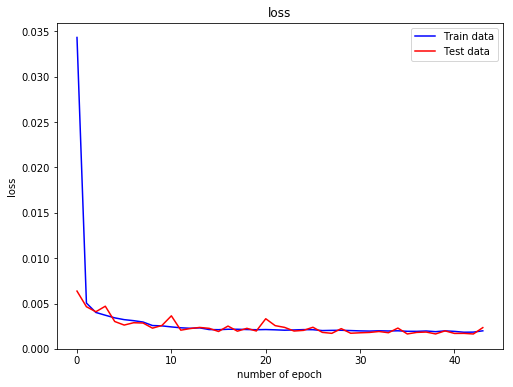

epoch [44/100], train loss:0.0020, test loss:0.0023, best test loss:0.0016


In [111]:
num_epochs = 100
train_loss = []
test_loss = []
best_test_loss = np.inf
try:
    for epoch in range(num_epochs):
        train_loss_per_epoch = [] 
        test_loss_per_epoch = []
        
        for data in dataloader:
            img, label = data
            img = img.view(img.size(0), -1)
            
            for other_data in other_dataloader:
                other_img, _ = other_data
                other_img = other_img[:img.size(0)]
                other_img = other_img.view(other_img.size(0), -1)
                break
            
            target = []
            for i in range(img.shape[0]):
                target.append(torch.tensor(pearsonr(img[i].numpy(), other_img[i].numpy())[0]))
            target = torch.stack(target).unsqueeze(1)

            with torch.no_grad():
                encodding = model2.encoder(img)

            output = parametric_function4(encodding, other_img)

            loss = criterion(output, target)
            train_loss_per_epoch.append(loss.item())

            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss.append(np.mean(train_loss_per_epoch))
            
        with torch.no_grad():
            for data in test_loader:
                img, label = data
                img = img.view(img.size(0), -1)
                
                for other_data in other_test_loader:
                    other_img, _ = other_data
                    other_img = other_img.view(other_img.size(0), -1)
                    break
                
                target = []
                for i in range(img.shape[0]):
                    target.append(torch.tensor(pearsonr(img[i].numpy(), other_img[i].numpy())[0]))
                target = torch.stack(target).unsqueeze(1)
            
                encodding = model2.encoder(img)
                output = parametric_function4(encodding, other_img)
                
                loss = criterion(output, target)
                test_loss_per_epoch.append(loss.item())
                
            test_loss.append(np.mean(test_loss_per_epoch))
        # ===================log========================
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("loss")
        plt.xlabel("number of epoch")
        plt.ylabel("loss")
        plt.plot(train_loss, 'b', label = "Train data")
        plt.plot(test_loss, 'r', label = "Test data")
        plt.legend()
        plt.show()
            
        print('epoch [{}/{}], train loss:{:.4f}, test loss:{:.4f}, best test loss:{:.4f}'
              .format(epoch + 1, num_epochs, np.mean(train_loss_per_epoch), np.mean(test_loss_per_epoch),
                     best_test_loss))
        
        
        if test_loss[-1] < best_test_loss:
            best_test_loss = test_loss[-1]
            torch.save(model.state_dict(), f"./parametric_functio4.pth")
                
except KeyboardInterrupt:
    pass

In [120]:
pd.DataFrame({'best test mse': [0.0016, 0.0011], 
 'train mse': [0.0020, 0.0014]},
            index = ['size: 32', 'size: 64'])

,best test mse,train mse
size: 32,0.0016,0.0020
size: 64,0.0011,0.0014


Here encoder with larger latent space gives better quality.

### Как можно адаптировать процедуру обучения автоэнкодера, чтобы улучшать точность расчета Ф на скрытом пространстве?


1. One of the ideas is to change the size of the latent space, which was done

2. The other idea is to change the loss function for the autoencoder, e.g. adding some regularization based on the specific task. This was not done yet. Also need to look at more relevant to the history matching task rahther than toy mnist examples. 